In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

xhlulu_140k_real_and_fake_faces_path = kagglehub.dataset_download('xhlulu/140k-real-and-fake-faces')
sokhnaballytour_test_progan_path = kagglehub.dataset_download('sokhnaballytour/test-progan')
sokhnaballytour_val_dataset_path = kagglehub.dataset_download('sokhnaballytour/val-dataset')
sokhnaballytour_train_dataset_path = kagglehub.dataset_download('sokhnaballytour/train-dataset')

print('Data source import complete.')


In [ ]:
from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torchvision.datasets import ImageFolder

In [ ]:
# Définir les transformations pour les images
transform = Compose([
    Resize((224, 224)),  # Redimensionner les images à la taille attendue par ViT
    ToTensor(),  # Convertir en tenseur
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser
])

# Charger les datasets
train_dataset = ImageFolder(root="/kaggle/input/train-dataset/train_dataset", transform=transform)
valid_dataset = ImageFolder(root="/kaggle/input/val-dataset/val_dataset", transform=transform)
test_dataset = ImageFolder(root="/kaggle/input/test-progan/progan/person", transform=transform)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ViT Transfert Learning

In [ ]:
# Charger le modèle ViT pré-entraîné
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,  # 2 classes : fake et real
    ignore_mismatched_sizes=True  # Ignorer les incompatibilités de taille
)

# Charger le feature extractor (pour le prétraitement des images)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Définir l'optimiseur et la fonction de perte
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Boucle d'entraînement
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):  # Ici, batch est un tuple (images, labels)
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

100%|██████████| 3125/3125 [1:09:29<00:00,  1.33s/it]


Epoch 1, Loss: 0.03446152218693285


100%|██████████| 3125/3125 [1:04:53<00:00,  1.25s/it]


Epoch 2, Loss: 0.0137041156893273


100%|██████████| 3125/3125 [1:02:20<00:00,  1.20s/it]

Epoch 3, Loss: 0.010491032321718666


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(valid_loader):  # Ici, batch est un tuple (images, labels)
        images, labels = images.to(device), labels.to(device)

        outputs = model(pixel_values=images)
        _, predicted = torch.max(outputs.logits, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total}%")

100%|██████████| 625/625 [06:31<00:00,  1.60it/s]

Validation Accuracy: 99.19%


In [ ]:
import torch
import numpy as np
from torchmetrics import CohenKappa
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    f1_score,
    confusion_matrix,
    cohen_kappa_score,
    log_loss,
    recall_score,
    precision_score,
)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mettre le modèle en mode évaluation
model.eval()

# Initialiser les listes pour stocker les prédictions et les étiquettes
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Obtenir les prédictions du modèle
        outputs = model(images)  # Retourne directement les logits
        probs = torch.softmax(outputs.logits, dim=1)
  # Appliquer softmax directement sur les logits
        _, preds = torch.max(probs, 1)

        # Stocker les prédictions, les étiquettes et les probabilités
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en arrays numpy et calculer les métriques
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculer et afficher les métriques
accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs[:, 1])
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 625/625 [06:55<00:00,  1.50it/s]

Accuracy: 0.9925
AUC: 0.9999
MCC: 0.9851
F1-score: 0.9925
Specificity: 0.9862
Cohen's Kappa: 0.9850
Log Loss: 0.0203
Recall: 0.9988
Precision: 0.9864


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import math

# Définir les transformations pour les images
transform = Compose([
    Resize((224, 224)),  # Redimensionner les images à la taille attendue par ViT
    ToTensor(),  # Convertir en tenseur
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser
])

# Charger les datasets
train_dataset = ImageFolder(root="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train", transform=transform)
valid_dataset = ImageFolder(root="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid", transform=transform)
test_dataset = ImageFolder(root="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test", transform=transform)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class LatentAttention(nn.Module):
    def __init__(self, dim, num_latents=128):
        super().__init__()
        self.dim = dim
        self.L = num_latents

        # Initialisation normalisée des paramètres
        self.wq = nn.Parameter(torch.randn(num_latents, dim) / math.sqrt(dim))
        self.wk = nn.Parameter(torch.randn(num_latents, dim) / math.sqrt(dim))
        self.wv = nn.Linear(dim, dim)

        # Convolution 1D au lieu de 2D
        self.conv1d = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Calcul des projections avec mise à l'échelle
        K = torch.einsum('ld,bsd->bls', self.wk, x)
        V = self.wv(x)
        Q = torch.einsum('ld,bsd->bls', self.wq, x)

        # Normalisation des distributions de probabilité
        p_l_t = F.softmax(Q / math.sqrt(self.dim), dim=1)
        p_s_l = F.softmax(K / math.sqrt(self.dim), dim=1)

        # Attention latente
        attention = torch.einsum('bls,bls,bsd->bsd', p_l_t, p_s_l, V)

        # Convolution 1D au lieu de 2D
        attention = attention.permute(0, 2, 1)  # [B, D, S]
        attention = self.conv1d(attention)
        attention = attention.permute(0, 2, 1)  # [B, S, D]

        return attention

class CustomViTWithLatentAttention(nn.Module):
    def __init__(self, num_classes=2, num_latents=128):
        super().__init__()

        # Charger le ViT pré-entraîné
        self.vit = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # Geler les couches du ViT
        for param in self.vit.vit.embeddings.parameters():
            param.requires_grad = False
        for param in self.vit.vit.encoder.layer[:8].parameters():
            param.requires_grad = False

        # Remplacer l'attention standard par Latent Attention
        self.hidden_dim = 768
        self.latent_attention = LatentAttention(self.hidden_dim, num_latents)

        # Couche de classification
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.LayerNorm(self.hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(self.hidden_dim // 2, num_classes)
        )

    def forward(self, pixel_values):
        outputs = self.vit.vit(pixel_values)
        hidden_states = outputs.last_hidden_state  # [B, T, D]

        # Appliquer Latent Attention
        attended = self.latent_attention(hidden_states)

        # Classification
        logits = self.classifier(attended.mean(dim=1))
        return logits

# Fonction d'entraînement

def train_model(model, train_loader, valid_loader, epochs=10, device='cuda'):
    model = model.to(device)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
    criterion = CrossEntropyLoss()

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_accuracy = 0.0, 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            running_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = running_accuracy / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation
        model.eval()
        valid_loss, valid_accuracy = 0.0, 0.0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                valid_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_accuracy /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # ROC-AUC
        roc_auc = roc_auc_score(all_labels, all_preds)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, "
              f"Valid ROC-AUC: {roc_auc:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, all_labels, all_preds

# Initialisation
model = CustomViTWithLatentAttention(num_classes=2)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()


def plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

def plot_roc_curve(all_labels, all_preds):
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Entraînement et validation
train_losses, valid_losses, train_accuracies, valid_accuracies, all_labels, all_preds = train_model(
    model, train_loader, valid_loader, epochs=10, device='cuda'
)

Epoch 1/10: 100%|██████████| 3125/3125 [48:46<00:00,  1.07it/s]


Epoch 1/10, Train Loss: 0.0890, Train Accuracy: 0.9628, Valid Loss: 0.0378, Valid Accuracy: 0.9869, Valid ROC-AUC: 0.9869


Epoch 2/10: 100%|██████████| 3125/3125 [40:17<00:00,  1.29it/s]


Epoch 2/10, Train Loss: 0.0166, Train Accuracy: 0.9947, Valid Loss: 0.0214, Valid Accuracy: 0.9923, Valid ROC-AUC: 0.9923


Epoch 3/10: 100%|██████████| 3125/3125 [40:14<00:00,  1.29it/s]


Epoch 3/10, Train Loss: 0.0091, Train Accuracy: 0.9970, Valid Loss: 0.0226, Valid Accuracy: 0.9931, Valid ROC-AUC: 0.9931


Epoch 4/10: 100%|██████████| 3125/3125 [40:16<00:00,  1.29it/s]


Epoch 4/10, Train Loss: 0.0064, Train Accuracy: 0.9980, Valid Loss: 0.0242, Valid Accuracy: 0.9936, Valid ROC-AUC: 0.9935


Epoch 5/10: 100%|██████████| 3125/3125 [40:13<00:00,  1.29it/s]


Epoch 5/10, Train Loss: 0.0051, Train Accuracy: 0.9984, Valid Loss: 0.0201, Valid Accuracy: 0.9945, Valid ROC-AUC: 0.9945


Epoch 6/10: 100%|██████████| 3125/3125 [40:20<00:00,  1.29it/s]


Epoch 6/10, Train Loss: 0.0043, Train Accuracy: 0.9986, Valid Loss: 0.0227, Valid Accuracy: 0.9937, Valid ROC-AUC: 0.9937


Epoch 7/10: 100%|██████████| 3125/3125 [40:15<00:00,  1.29it/s]


Epoch 7/10, Train Loss: 0.0030, Train Accuracy: 0.9990, Valid Loss: 0.0196, Valid Accuracy: 0.9937, Valid ROC-AUC: 0.9936


Epoch 8/10: 100%|██████████| 3125/3125 [40:41<00:00,  1.28it/s]


Epoch 8/10, Train Loss: 0.0035, Train Accuracy: 0.9988, Valid Loss: 0.0223, Valid Accuracy: 0.9944, Valid ROC-AUC: 0.9944


Epoch 9/10: 100%|██████████| 3125/3125 [40:19<00:00,  1.29it/s]


Epoch 9/10, Train Loss: 0.0026, Train Accuracy: 0.9992, Valid Loss: 0.0213, Valid Accuracy: 0.9936, Valid ROC-AUC: 0.9935


Epoch 10/10: 100%|██████████| 3125/3125 [40:18<00:00,  1.29it/s]


Epoch 10/10, Train Loss: 0.0026, Train Accuracy: 0.9992, Valid Loss: 0.0241, Valid Accuracy: 0.9931, Valid ROC-AUC: 0.9931


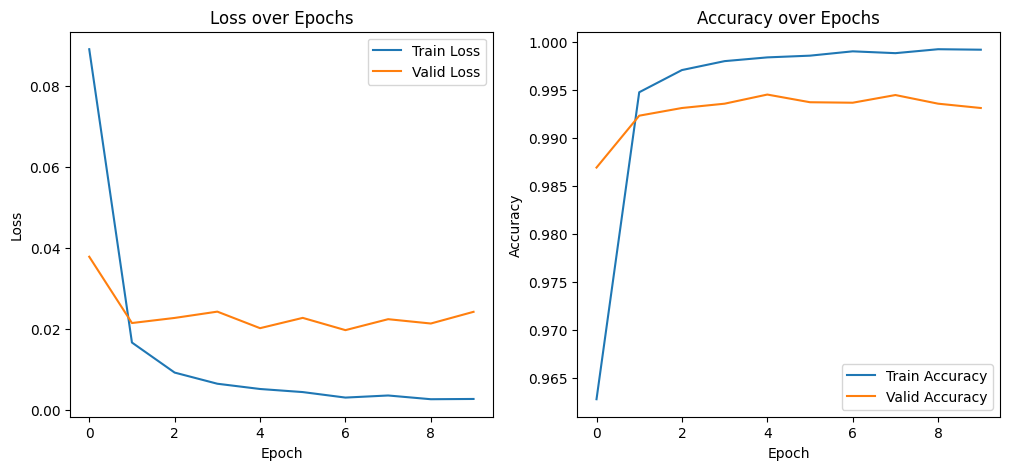

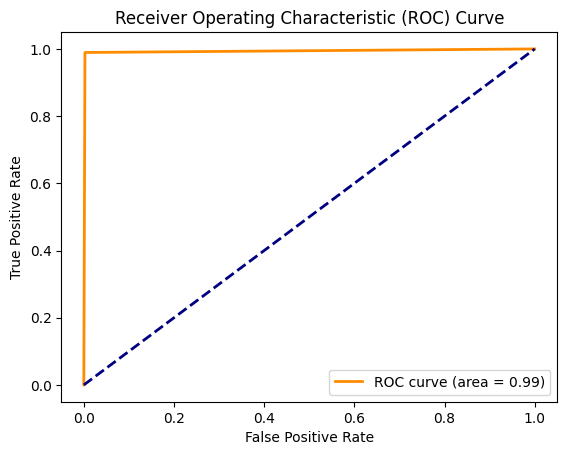

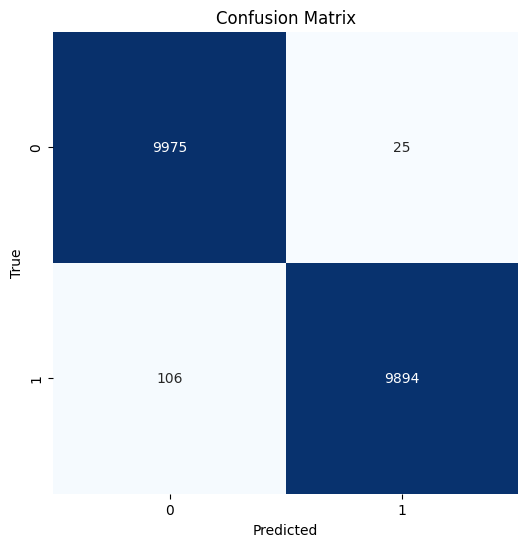

In [ ]:
from sklearn.metrics import auc  # Réimporter correctement la fonction

# Tracer les courbes de loss et d'accuracy
plot_metrics(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Tracer la courbe ROC-AUC
plot_roc_curve(all_labels, all_preds)

# Afficher la matrice de confusion
plot_confusion_matrix(all_labels, all_preds)

In [ ]:
import torch
import numpy as np
from torchmetrics import CohenKappa
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    f1_score,
    confusion_matrix,
    cohen_kappa_score,
    log_loss,
    recall_score,
    precision_score,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Mettre le modèle en mode évaluation
model.eval()

# Initialiser les listes pour stocker les prédictions et les étiquettes
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Déplacer les données sur le GPU
        images, labels = images.to(device), labels.to(device)

        # Obtenir les prédictions du modèle
        outputs = model(images)  # Retourne directement les logits
        probs = torch.softmax(outputs, dim=1)  # Appliquer softmax directement sur les logits
        _, preds = torch.max(probs, 1)

        # Stocker les prédictions, les étiquettes et les probabilités
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convertir en arrays numpy et calculer les métriques
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculer et afficher les métriques
accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs[:, 1])
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
logloss = log_loss(all_labels, all_probs)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

100%|██████████| 625/625 [07:30<00:00,  1.39it/s]

Accuracy: 0.9935
AUC: 0.9998
MCC: 0.9869
F1-score: 0.9934
Specificity: 0.9975
Cohen's Kappa: 0.9869
Log Loss: 0.0241
Recall: 0.9894
Precision: 0.9975
